In [45]:
import numpy as np
import pandas as pd

# data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# evaluation metrics and class balancing
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# deep learning frameworks
import keras
import tensorflow as tf

# image preprocessing tools
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import save_model

# model architecture and training utilities
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [50]:
# dataset paths
train_path = './chest_xray/train'
test_path = './chest_xray/test'
valid_path = './chest_xray/val'

# define standard parameter values
batch_size = 16
img_height = 224
img_width = 224

In [51]:
image_gen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,width_shift_range=0.2,
    height_shift_range=0.2,rotation_range=25)

# rescaling for validation and test images (no augmentation)
test_data_gen = ImageDataGenerator(rescale=1./255)

In [52]:
train = image_gen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=batch_size
)

# load and preprocess test images (no augmentation, no shuffle)
test = test_data_gen.flow_from_directory(
    test_path,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    shuffle=False,
    class_mode='binary',
    batch_size=batch_size
)

# load and preprocess validation images (no augmentation)
valid = test_data_gen.flow_from_directory(
    valid_path,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=batch_size
)

Found 4 images belonging to 2 classes.
Found 2 images belonging to 2 classes.
Found 2 images belonging to 2 classes.


IndexError: index 2 is out of bounds for axis 0 with size 2

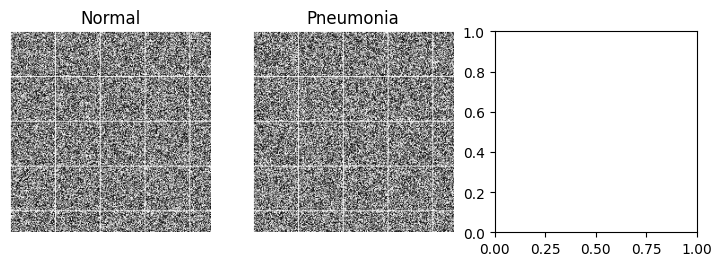

In [53]:
import matplotlib.pyplot as plt
import numpy as np

images, labels = next(test) 

plt.figure(figsize=(12, 12))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i], cmap='gray') 
    plt.title("Pneumonia" if labels[i] == 1 else "Normal")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
model= Sequential()

model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))  # downsampling

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(256, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
early = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=5,restore_best_weights=True
)

# reduce learning rate when validation loss plateaus
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    verbose=1,
    factor=0.3,
    min_lr=1e-6
)

weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train.classes),
    y=train.classes
)

# convert weights to dictionary format expected by Keras
cw = dict(zip(np.unique(train.classes), weights))

In [ ]:
history= model.fit(
    train,
    epochs=45,
    validation_data=valid,
    class_weight=cw,
    callbacks=[early,learning_rate_reduction]  
)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_true = test.classes

y_pred_proba = model.predict(test, verbose=1)
y_pred = (y_pred_proba > 0.5).astype("int32").reshape(-1)

target_names = list(test.class_indices.keys())  # ['NORMAL', 'PNEUMONIA']

print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Prediction')
plt.ylabel('Variable')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
correct=np.sum(y_true==y_pred)
incorrect=np.sum(y_true!=y_pred)
print("Correct : ",correct)
print("Incorrect : ",incorrect)

In [ ]:
plt.pie(x=[correct,incorrect],labels=['Correct','Incorrect'],startangle=45,explode=[0.07,0.07],autopct='%1.1f%%')